In [281]:
#imports
import pandas as pd
import matplotlib.pyplot as plt # for visualizations
import seaborn as sns # for visualizations
import numpy as np

#model packages
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import statsmodels.api as sm #linear regression tool
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#Pre-processing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing #for normalizing values
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [282]:
#read the csv to a dataframe
df = pd.read_csv("../data/salary-cap-data.csv", encoding= 'utf-8')
df.info() #check to ensure it worked
df.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Team            192 non-null    object 
 1   Year            192 non-null    int64  
 2   Wins            192 non-null    int64  
 3   Losses          192 non-null    int64  
 4   Ties            192 non-null    int64  
 5   Classification  192 non-null    object 
 6   QB              192 non-null    int64  
 7   RB              192 non-null    int64  
 8   WR              192 non-null    int64  
 9   TE              192 non-null    int64  
 10  OL              192 non-null    int64  
 11  Offense         192 non-null    int64  
 12  DL              192 non-null    int64  
 13  LB              192 non-null    int64  
 14  S               192 non-null    int64  
 15  CB              192 non-null    int64  
 16  Defense         192 non-null    int64  
 17  SpecialTeams    192 non-null    int

,Team,Year,Wins,Losses,Ties,Classification,QB,RB,WR,TE,...,DL,LB,S,CB,Defense,SpecialTeams,DeadMoney,Total,CapMax,PercentUsed
0,49ers,2013,12,4,0,Good,2843160,9257768,16945177,10569598,...,11028483,17860800,10696955,12885741,52471979,6831666,6601496,116398504,123000000,0.946329
1,Bears,2013,8,8,0,Mediocre,11276471,12036166,16580067,2495000,...,29744128,12474915,3802254,15375000,61396297,6290000,2854947,120145053,123000000,0.976789


In [283]:
X_train, X_test = train_test_split(df, test_size = 0.2) # splits the data into two parts with 1:4 ratio
print(X_train.shape)
print(X_test.shape)

(153, 22)
(39, 22)


In [284]:
#set the training and testing data
X = X_train[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
y = X_train.Wins
X = sm.add_constant(X) #add the constant to the model
mod = sm.OLS(y, X, hasconst= True) #create the ordinary least squares model
res = mod.fit() #fit the model
print(res.summary()) #summarize the model

                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     2.768
Date:                Tue, 13 Oct 2020   Prob (F-statistic):            0.00278
Time:                        15:02:53   Log-Likelihood:                -376.54
No. Observations:                 153   AIC:                             777.1
Df Residuals:                     141   BIC:                             813.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.3183      2.770     -1.920   

In [285]:
#create the tests sets
Xtest = X_test[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
ytest = X_test.Wins #wins is the predicted dependent variable
Xtest = sm.add_constant(Xtest)

res.predict(Xtest);  #predict based off the test input

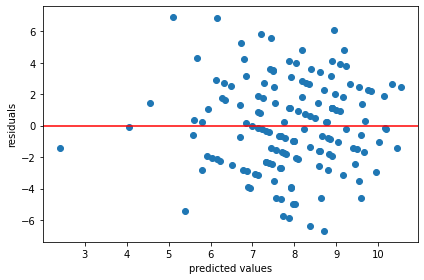

In [286]:
#plot the residuals
residuals = res.resid

y_pred = res.predict(X)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color = 'red', label = '0')

plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.tight_layout()

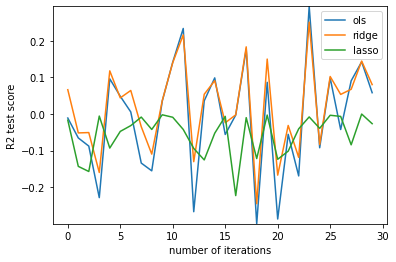

In [287]:
#in this model, there is collinearity between the different features - they are not entirely independent
#for example, if a team spends more on a quarterback, they will have to spend less elsewhere.. what they spend
#on a certain position depends on what they spent on the rest.
#for that reason, ridge or lasso regression may give better results than the standard linear regression
#lets try it out below...

#this from the lecture notes...
def model_experiment(num_iter = 5, 
                     models = ['ols', 'ridge', 'lasso'], alpha= 10, 
                     complexity = 'simple', degree = 3):
    
    X_train, X_test = train_test_split(df, test_size = 0.2) # splits the data into two parts with 1:4 ratio
    X = X_train[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
    y = X_train.Wins
    
    x_axis = np.arange(num_iter)
    y_ols_test = []
    y_lasso_test = []
    y_ridge_test = []
    sample_models = {}
    for i in range(num_iter):
        
        if complexity == 'simple':
            ## split train_test 
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        elif complexity == 'polynomial':
            ## Create higher order terms
            poly = PolynomialFeatures(degree=degree)
            Xp = poly.fit_transform(X)
            ## test-train split
            X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = 0.2)


        ## Standard scale mean = 0, variance = 1
        sd = StandardScaler()

        sd.fit(X_train)

        X_train = sd.transform(X_train)

        X_test = sd.transform(X_test)

        ## Be careful about the leakage

        ## Vanilla model
        if 'ols' in models:
            lr = LinearRegression()

            lr.fit(X_train, y_train)
            
            sample_models['ols'] = lr

            test_score = lr.score(X_test, y_test)
            train_score = lr.score(X_train, y_train)

            y_ols_test.append(test_score)

    #       print('test score OLS is %.2f and train score is %.2f'%(test_score, train_score))

        if 'ridge' in models:
            ## Ridge in the simple setting
            ridge = Ridge(alpha = alpha, max_iter= 10000)
            ridge.fit(X_train, y_train)
            sample_models['ridge'] = ridge
            y_ridge_test.append(ridge.score(X_test, y_test))
    #         print('test score Ridge is %.2f and train score is %.2f'%(ridge.score(X_test, y_test),
    #                                                             ridge.score(X_train, y_train)))

        if 'lasso' in models:
            ## Lasso in the simple setting
            lasso = Lasso(alpha = alpha, max_iter= 10000)

            lasso.fit(X_train, y_train)
            
            sample_models['lasso'] = lasso
            
            y_lasso_test.append(lasso.score(X_test, y_test))
    #       print('test score Lasso is %.2f and train score is %.2f'%(lasso.score(X_test, y_test),
    #                                                             lasso.score(X_train, y_train)))

        i+=1
    if 'ols' in models:
        plt.plot(y_ols_test, label = 'ols')
    if 'ridge' in models:
        plt.plot(y_ridge_test, label = 'ridge')
    if 'lasso' in models:
        plt.plot(y_lasso_test, label = 'lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    all_results = y_ols_test + y_lasso_test + y_ridge_test
    plt.ylim((np.min(all_results), np.max(all_results)))
    
    plt.legend()
    return sample_models

trained_models = model_experiment(num_iter=30, alpha = 30,
                                   models = ['ols', 'ridge', 'lasso'], 
                                   complexity= 'simple', degree = 3)


In [288]:
# After run model_experiment with complexity == 'polynomial'

lr_ols = trained_models['ols']
lr_lasso = trained_models['lasso']
lr_ridge =trained_models['ridge']

# check the coefficients from Lasso

print(lr_ridge.coef_)
print(lr_lasso.coef_)

# compare them with OLS/Ridge models.

[ 0.08118188  0.13591967  0.08018133  0.11080117 -0.1587397   0.00470622
  0.27957912  0.28489231 -0.38507401  0.19456929  0.87534321]
[ 0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.]


In [289]:
def normalize(x, col_max, col_min):
    return ((x - col_min) / (col_max - col_min))

#normalize the values for each position
for position in ['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams']:
    df['norm' + position] = df[position].apply(lambda x: normalize(x, df[position].max(), df[position].min()))
df.head(2)

,Team,Year,Wins,Losses,Ties,Classification,QB,RB,WR,TE,...,normQB,normRB,normWR,normTE,normOL,normDL,normLB,normS,normCB,normSpecialTeams
0,49ers,2013,12,4,0,Good,2843160,9257768,16945177,10569598,...,0.045792,0.496506,0.445637,0.601705,0.303146,0.124968,0.362279,0.347406,0.365889,0.631449
1,Bears,2013,8,8,0,Mediocre,11276471,12036166,16580067,2495000,...,0.273408,0.672399,0.433855,0.080535,0.102124,0.519290,0.223023,0.058773,0.448341,0.571961


In [290]:
#lets try linear regression again
X_train, X_test = train_test_split(df, test_size = 0.2) # splits the data into two parts with 1:4 ratio
print(X_train.shape)
print(X_test.shape)

(153, 32)
(39, 32)


In [291]:
#set the training and testing data
X = X_train[['normQB','normRB', 'normWR', 'normTE', 'normOL', 'normDL', 'normLB', 'normS', 'normCB', 'normSpecialTeams', 'PercentUsed']]
y = X_train.Wins
X = sm.add_constant(X) #add the constant to the model
mod = sm.OLS(y, X, hasconst= True) #create the ordinary least squares model
res = mod.fit() #fit the model
print(res.summary()) #summarize the model


#####
#NOTE:
#it turns out this is no better than the original model - normalizing in this way doesn't do anything just makes
#the coeficients larger as the feature values are smaller which does nothing for the accuracy
#Probably an experiment that did not need to be done...
#####

                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     3.774
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           9.44e-05
Time:                        15:03:14   Log-Likelihood:                -367.00
No. Observations:                 153   AIC:                             758.0
Df Residuals:                     141   BIC:                             794.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.9662      2.461  

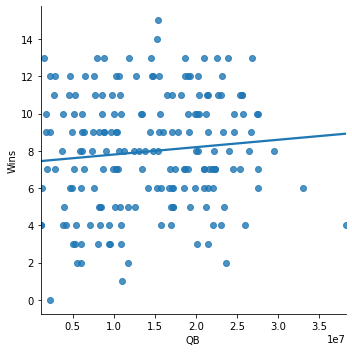

In [292]:
## let's use seaborn to plot a regression line
sns.lmplot(x = 'QB', y = 'Wins', data = df, ci = 0)
plt.draw()

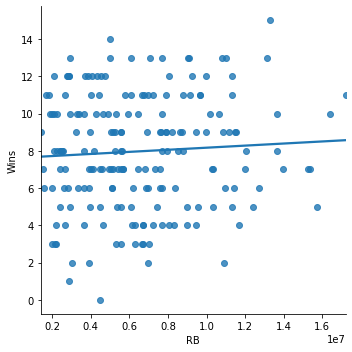

In [293]:
## let's use seaborn to plot a regression line
sns.lmplot(x = 'RB', y = 'Wins', data = df, ci = 0)
plt.draw()

In [294]:
#from the lecture notes...
def draw_tree(estimator, figsize =(15, 5), feature_names = ["Hits", "Years"]):
    """
    Takes a decision  tree estimator and plots it's tree structure
    :param estimator: A sklearn decision tree estimator. Should be fitted.
    :param figsize: tuple. (int, int).
    :param feature_names:
    :return: It returns a plot. The image is not saved.
    """
    fig = plt.figure(figsize= figsize)
    _ = tree.plot_tree(estimator,
                       feature_names= feature_names,
                       filled=True)

         QB        RB        WR        TE        OL        DL        LB  \
0   2843160   9257768  16945177  10569598  17479156  11028483  17860800   
1  11276471  12036166  16580067   2495000  10071052  29744128  12474915   

          S        CB  SpecialTeams  PercentUsed  
0  10696955  12885741       6831666     0.946329  
1   3802254  15375000       6290000     0.976789  
[[ 2 11  3]
 [ 0  6  2]
 [ 2  8  5]]
              precision    recall  f1-score   support

         Bad       0.50      0.12      0.20        16
        Good       0.24      0.75      0.36         8
    Mediocre       0.50      0.33      0.40        15

    accuracy                           0.33        39
   macro avg       0.41      0.40      0.32        39
weighted avg       0.45      0.33      0.31        39



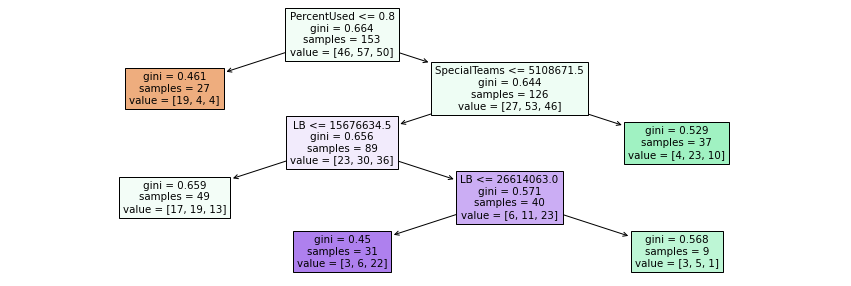

In [295]:
## here let's apply sklearn DecisionTreeClassifier
X = df.drop(['Team', 'Year', 'Wins', 'Losses', 'Ties', 'Classification', 'Offense', 'Defense', 'Total', 'DeadMoney', 'CapMax', 'normQB','normRB', 'normWR', 'normTE', 'normOL', 'normDL', 'normLB', 'normS', 'normCB', 'normSpecialTeams'], axis=1)
y = df['Classification']
print(X.head(2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

classifier = DecisionTreeClassifier(max_leaf_nodes= 5)
#classifier = DecisionTreeClassifier(max_depth=None)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

draw_tree(classifier,feature_names= X_train.columns)


In [296]:
#use cross-validation with the decision tree...
depth = []
for i in range(3,100):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    # Perform 10-fold cross validation 
    scores = cross_val_score(estimator=clf, X=x, y=y, cv=10, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)

[(3, 0.34947368421052627), (4, 0.3594736842105263), (5, 0.33421052631578946), (6, 0.29184210526315785), (7, 0.32842105263157895), (8, 0.3026315789473684), (9, 0.28210526315789475), (10, 0.29684210526315785), (11, 0.31263157894736837), (12, 0.28105263157894733), (13, 0.3231578947368421), (14, 0.3286842105263158), (15, 0.3339473684210526), (16, 0.29210526315789476), (17, 0.3444736842105263), (18, 0.3231578947368421), (19, 0.31263157894736837), (20, 0.30236842105263156), (21, 0.32368421052631574), (22, 0.3026315789473684), (23, 0.3284210526315789), (24, 0.32894736842105254), (25, 0.2913157894736842), (26, 0.32342105263157894), (27, 0.3128947368421052), (28, 0.3284210526315789), (29, 0.3381578947368421), (30, 0.31263157894736837), (31, 0.32342105263157894), (32, 0.34368421052631576), (33, 0.31210526315789466), (34, 0.30684210526315786), (35, 0.30157894736842106), (36, 0.32868421052631575), (37, 0.2863157894736842), (38, 0.3126315789473684), (39, 0.28657894736842104), (40, 0.307368421052631

In [299]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

## drop everything except the predictors of 'QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed'
X = df.drop(['Team', 'Year', 'Wins', 'Losses', 'Ties', 'Classification', 'Offense', 'Defense', 'Total', 'DeadMoney', 'CapMax', 'normQB','normRB', 'normWR', 'normTE', 'normOL', 'normDL', 'normLB', 'normS', 'normCB', 'normSpecialTeams'], axis=1)
y = df['Classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3076923076923077
